# Imports

In [1]:
import sys
import os

# Добавляем корневую директорию проекта в Python path
sys.path.append(os.path.join(os.getcwd(), '..'))

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

SEED=12
np.random.seed(SEED)

# %matplotlib inline

# Data

In [2]:
# train_df = pd.read_csv("sales_train_evaluation.csv")
# train_df.shape

In [3]:
# val_df = pd.read_csv("sales_train_validation.csv")
# val_df.shape

In [4]:
passengers_df = pd.read_csv("../data/air-passengers.csv")
display(passengers_df.shape)
display(passengers_df.head())

# # Параметры шума
# noise_lst = [0.15, 0.1, 0.05] # Уровень шума (5% от значений)
# for noise_level in noise_lst:
#     noise = np.random.normal(0, noise_level * passengers_df['Passengers'].mean(), len(passengers_df))

#     # Добавление шума
#     passengers_df[f'Passengers_Noisy_{noise_level}_seed{SEED}'] = passengers_df['Passengers'] + noise
#     passengers_df[f'Passengers_Noisy_{noise_level}_seed{SEED}'] = passengers_df[f'Passengers_Noisy_{noise_level}_seed{SEED}'].round().astype(int)  # Округление до целых

# passengers_df.head()
# passengers_df.to_csv('air-passengers.csv', index=False)

(144, 5)

,Month,Passengers,Passengers_Noisy_0.15_seed12,Passengers_Noisy_0.1_seed12,Passengers_Noisy_0.05_seed12
0,1949-01,112,63,137,120
1,1949-02,118,188,93,131
2,1949-03,132,158,184,159
3,1949-04,129,138,137,135
4,1949-05,121,134,116,123


In [5]:
# #2985 сезонный ряд, тк видим повторяющийся паттерн каждые 7 лагов

# #1337 HOUSEHOLD_2_242_CA_1_evaluation ряд шумный
# #28581 HOUSEHOLD_2_044_WI_3_evaluation только тренд
# #30426 FOODS_3_764_WI_3_evaluation трендом, сезонностю(годовая) + шум
# #2810 FOODS_3_586_CA_1_evaluation сезонность(годовая) + шум
# #air-passengers тренд + сезонность(месячная)
# def plot_series(indx_lst: list, with_stl_decomposition: bool = False):
#     '''рисует ряды, указанные в indx_lst
#     indx_lst - список индексов рядов в train_df, которые нужно нарисовать
#     '''

#     if not with_stl_decomposition:

#         plt.figure(figsize=(10, 2 * len(indx_lst)))
#         for i, ind in enumerate(indx_lst):
#             plt.subplot(len(indx_lst), 1, i + 1)
#             row = train_df.iloc[ind]
#             series_id = row["id"]
#             var = np.var(train_df.drop(columns=["id","item_id", "dept_id", "cat_id", "store_id", "state_id"]).iloc[ind].values)
#             plt.plot(train_df.drop(columns=["id","item_id", "dept_id", "cat_id", "store_id", "state_id"]).iloc[ind].values)
#             plt.title(f"{ind} {series_id}, var= {var:.2f}")
#             plt.xlabel("Day")
#             plt.ylabel("Units sold")
            
    
#     else:
#         plt.figure(figsize=(11, 5 * len(indx_lst)))
#         for ind in indx_lst:
#             result = calculate_stl_features(train_df.iloc[ind].filter(like='d_'), period=365)
#             result['stl_result'].plot()
#             plt.suptitle(train_df.iloc[ind]["id"], fontsize=11)
#     plt.tight_layout()
#     plt.show()

# # plot_series([1337, 28581, 30426, 2810])

In [6]:
# #1337 HOUSEHOLD_2_242_CA_1_evaluation ряд шумный
# #28581 HOUSEHOLD_2_044_WI_3_evaluation только тренд
# #30426 FOODS_3_764_WI_3_evaluation трендом, сезонностю(годовая) + шум
# #2810 FOODS_3_586_CA_1_evaluation сезонность(годовая) + шум
# #air-passengers тренд + сезонность(месячная)
# plot_series([30426], with_stl_decomposition=True)

In [80]:
calendar = pd.read_csv("D:\quantile_regression\m5-forecasting-uncertainty\data\calendar.csv")
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


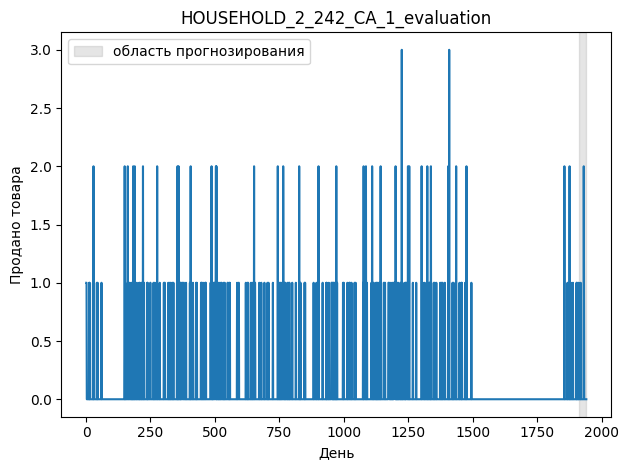

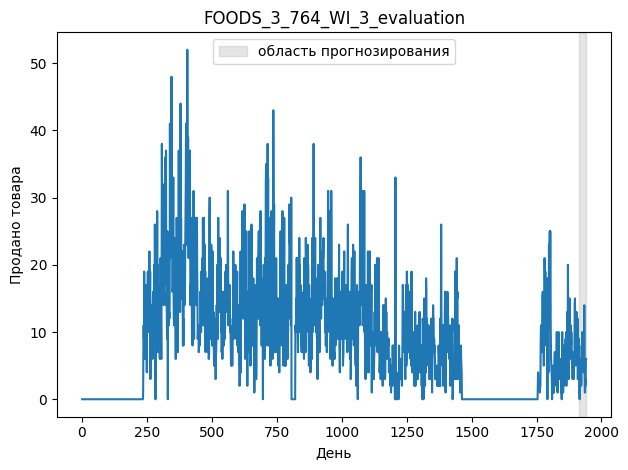

In [79]:
m5_data = pd.read_csv("D:\quantile_regression\m5-forecasting-uncertainty\data\sales_train_evaluation.csv")
y = m5_data[m5_data["id"] == "HOUSEHOLD_2_242_CA_1_evaluation"].filter(like='d_').values

def plot_m5_data(list_of_series_id: list) -> dict:
    for series_id in list_of_series_id:
        series_data = m5_data[m5_data["id"] == series_id].filter(like='d_').values.flatten()
        plt.plot(np.arange(1, len(series_data)+1), series_data)
        plt.title(series_id)
        plt.xlabel('День')
        plt.ylabel('Продано товара')
        plt.axvspan(len(series_data) - 28, len(series_data), color='#808080', alpha=0.2, label='область прогнозирования')
        plt.legend()
        plt.tight_layout()
        plt.show()

list_of_series_id = [
    "HOUSEHOLD_2_242_CA_1_evaluation",
    "FOODS_3_764_WI_3_evaluation"
]
plot_m5_data(list_of_series_id)

# Prophet

Начинаем подбор параметров...


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]




chain 1:  50%|█████     | 151/300 [00:03<00:03, 44.90it/s, (Sampling)]





chain 1:  83%|████████▎ | 250/300 [00:05<00:01, 45.18it/s, (Sampling)]




chain 2: 100%|██████████| 300/300 [00:07<00:00, 42.59it/s, (Sampling completed)]

chain 3: 100%|██████████| 300/300 [00:07<00:00, 42.60it/s, (Sampling completed)]


chain 4: 100%|██████████| 300/300 [00:07<00:00, 42.61it/s, (Sampling completed)]


21:46:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in


FIT TIME: 7.485889673233032


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]





chain 1:  33%|███▎      | 100/300 [00:06<00:13, 14.55it/s, (Warmup)]





chain 1:  50%|█████     | 151/300 [00:11<00:11, 13.28it/s, (Sampling)]

chain 1:  83%|████████▎ | 250/300 [00:16<00:03, 16.39it/s, (Sampling)]

chain 1: 100%|██████████| 300/300 [00:18<00:00, 17.30it/s, (Sampling)]

chain 2: 100%|██████████| 300/300 [00:21<00:00, 13.90it/s, (Sampling completed)]

chain 3: 100%|██████████| 300/300 [00:21<00:00, 13.90it/s, (Sampling completed)]


chain 4: 100%|██████████| 300/300 [00:21<00:00, 13.90it/s, (Sampling completed)]


21:46:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in


FIT TIME: 22.13023281097412


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]



chain 1:   0%|          | 1/300 [00:00<00:54,  5.53it/s, (Warmup)]

chain 1:  33%|███▎      | 100/300 [00:09<00:17, 11.14it/s, (Warmup)]


chain 1:  50%|█████     | 151/300 [00:14<00:14, 10.15it/s, (Sampling)]





chain 1:  83%|████████▎ | 250/300 [00:27<00:05,  8.75it/s, (Sampling)]


chain 1: 100%|██████████| 300/300 [00:32<00:00,  8.88it/s, (Sampling)]


chain 2: 100%|██████████| 300/300 [00:33<00:00,  8.88it/s, (Sampling completed)]

chain 3: 100%|██████████| 300/300 [00:33<00:00,  8.88it/s, (Sampling completed)]


chain 4: 100%|██████████| 300/300 [00:33<00:00,  8.88it/s, (Sampling completed)]


21:47:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 


FIT TIME: 34.226839542388916
Лучшие параметры: {'changepoint_prior_scale': 0.05, 'mcmc_samples': 300}


chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]



chain 1:   0%|          | 1/300 [00:00<01:04,  4.63it/s, (Warmup)]

chain 1:  33%|███▎      | 100/300 [00:04<00:09, 20.26it/s, (Warmup)]


chain 1:  50%|█████     | 151/300 [00:09<00:09, 14.90it/s, (Sampling)]










chain 2: 100%|██████████| 300/300 [00:21<00:00, 14.07it/s, (Sampling completed)]

chain 3: 100%|██████████| 300/300 [00:21<00:00, 14.07it/s, (Sampling completed)]


chain 4: 100%|██████████| 300/300 [00:21<00:00, 14.07it/s, (Sampling completed)]


21:47:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive

chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]


chain 1:   0%|          | 1/300 [00:00<00:30,  9.75it/s, (Warmup)]


chain 1:  33%|███▎      | 100/300 [00:06<00:12, 15.92it/s, (Warmup)]





chain 1:  50%|█████     | 151/300 [00:11<00:12, 12.33it/s, (Sampling)]





chain 2: 100%|██████████| 300/300 [00:23<00:00, 12.55it/s, (Sampling completed)]

chain 3: 100%|██████████| 300/300 [00:23<00:00, 12.55it/s, (Sampling completed)]


chain 4: 100%|██████████| 300/300 [00:23<00:00, 12.55it/s, (Sampling completed)]


21:48:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in

chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]





chain 1:  33%|███▎      | 100/300 [00:07<00:15, 13.29it/s, (Warmup)]





chain 1:  50%|█████     | 151/300 [00:12<00:12, 11.86it/s, (Sampling)]


chain 1:  83%|████████▎ | 250/300 [00:18<00:03, 14.27it/s, (Sampling)]


chain 2: 100%|██████████| 300/300 [00:20<00:00, 14.40it/s, (Sampling completed)]

chain 3: 100%|██████████| 300/300 [00:20<00:00, 14.40it/s, (Sampling completed)]


chain 4: 100%|██████████| 300/300 [00:20<00:00, 14.39it/s, (Sampling completed)]


21:48:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive

chain 1:   0%|          | 0/300 [00:00<?, ?it/s, (Warmup)]




chain 1:  33%|███▎      | 100/300 [00:06<00:12, 16.44it/s, (Warmup)]






chain 1:  50%|█████     | 151/300 [00:12<00:12, 11.52it/s, (Sampling)]




chain 2: 100%|██████████| 300/300 [00:25<00:00, 11.98it/s, (Sampling completed)]

chain 3: 100%|██████████| 300/300 [00:25<00:00, 11.99it/s, (Sampling completed)]


chain 4: 100%|██████████| 300/300 [00:25<00:00, 11.98it/s, (Sampling completed)]


21:48:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in



Результаты Pinball Loss:
Quantile 0.1: 0.0582
Quantile 0.25: 0.0776
Quantile 0.5: 0.0475
Quantile 0.75: 0.1004
Quantile 0.9: 0.0761


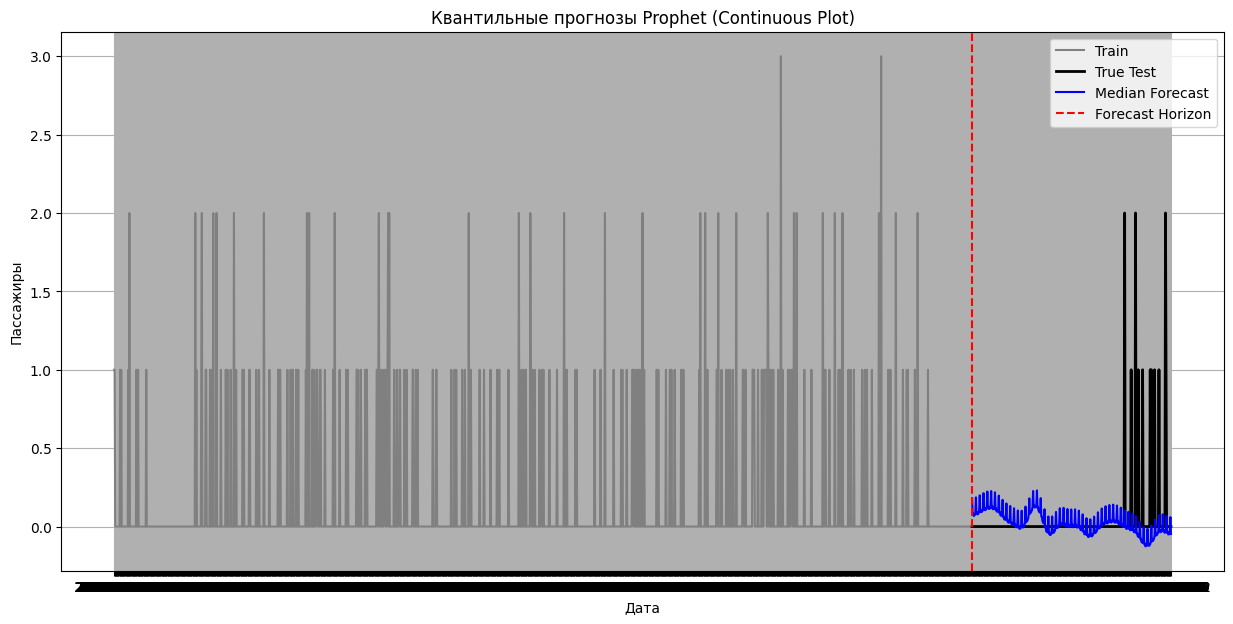

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_pinball_loss
import time

# 1. Подготовка данных
data = pd.DataFrame()
# data['ds'] = pd.to_datetime(passengers_df["Month"])
# data['y'] = passengers_df['Passengers']
M5_ID = "HOUSEHOLD_2_242_CA_1_evaluation"
data["ds"] = calendar["date"].iloc[:-28]
data['y'] = m5_data[m5_data["id"] == M5_ID].filter(like='d_').values.flatten()

# Разбиение
test_len = 365
train_size = len(data) - test_len
train, test = data.iloc[:train_size], data.iloc[train_size:]

# --- Функция метрики (Pinball Loss) ---
def pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))

# --- 2. Подбор гиперпараметров (без изменений) ---
params_grid = {
    # 'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1], 
    # 'seasonality_prior_scale': [1.0, 5., 10.0],
    'mcmc_samples': [300]
}

grid = ParameterGrid(params_grid)
best_params = {}
best_score = float('inf')

# Используем suppress output, чтобы не засорять лог
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print("Начинаем подбор параметров...")


for p in grid:
    m = Prophet(**p)
    start_time = time.time()
    m.fit(train)
    print(f'FIT TIME: {time.time() - start_time}')
    future = m.make_future_dataframe(periods=test_len, freq='D')
    forecast = m.predict(future)
    preds = forecast['yhat'].tail(test_len).values
    mae = mean_absolute_error(test['y'], preds)
    
    if mae < best_score:
        best_score = mae
        best_params = p

print(f"Лучшие параметры: {best_params}")

# --- 3. Построение Квантильных Прогнозов ---
target_quantiles = [0.10, 0.25, 0.5, 0.75, 0.90]

# Словари для хранения результатов
prophet_quantile_predictions = {} # Для расчета метрик (ровно 28 точек)
quantile_plots = {}   # Для графиков (29 точек, чтобы склеить линию)

# Вспомогательный словарь для ширины интервалов
interval_maps = {0.80: (0.10, 0.90), 0.50: (0.25, 0.75)}

# Генерируем future (один раз)
m_temp = Prophet(**best_params).fit(train)
future = m_temp.make_future_dataframe(periods=test_len, freq='D')

# 1. Медиана (0.5)
model_median = Prophet(**best_params) 
model_median.fit(train)
fcst_median = model_median.predict(future)

# Сохраняем для метрик (28 точек)
prophet_quantile_predictions[0.5] = fcst_median['yhat'].tail(test_len).values
# Сохраняем для графика (29 точек = 1 точка истории + 28 точек теста)
quantile_plots[0.5] = fcst_median['yhat'].tail(test_len + 1).values

# 2. Интервалы
for width, (q_low, q_high) in interval_maps.items():
    m = Prophet(interval_width=width, **best_params)
    m.fit(train)
    fcst = m.predict(future)
    
    # Для метрик
    prophet_quantile_predictions[q_low] = fcst['yhat_lower'].tail(test_len).values
    prophet_quantile_predictions[q_high] = fcst['yhat_upper'].tail(test_len).values
    
    # Для графика (захватываем +1 точку с конца обучения)
    quantile_plots[q_low] = fcst['yhat_lower'].tail(test_len + 1).values
    quantile_plots[q_high] = fcst['yhat_upper'].tail(test_len + 1).values

# --- 4. Оценка и Визуализация ---

# Оценка (используем prophet_quantile_predictions - 28 точек)
print("\nРезультаты Pinball Loss:")
for q in target_quantiles:
    loss = mean_pinball_loss(test['y'].values, prophet_quantile_predictions[q], alpha=q)
    print(f"Quantile {q}: {loss:.4f}")

# Визуализация (используем quantile_plots - 29 точек)
plt.figure(figsize=(15, 7))

# Рисуем весь ряд "True" одной линией для красоты, или разбиваем на Train/Test
plt.plot(train['ds'], train['y'], label='Train', color='gray')
plt.plot(data['ds'].tail(test_len + 1), data['y'].tail(test_len + 1), label='True Test', color='black', linewidth=2)

# Подготавливаем даты для графика (последняя дата train + все даты test)
plot_dates = data['ds'].tail(test_len + 1)

# Рисуем квантили (теперь они начинаются от линии горизонта)
# 5% - 95%
# plt.fill_between(plot_dates, 
#                  quantile_plots[0.10], 
#                  quantile_plots[0.90], 
#                  color='lightblue', alpha=0.3, label='90% confidence')

# 25% - 75%
# plt.fill_between(plot_dates, 
#                  quantile_plots[0.25], 
#                  quantile_plots[0.75], 
#                  color='blue', alpha=0.3, label='50% confidence')

# Медиана
plt.plot(plot_dates, quantile_plots[0.5], color='blue', label='Median Forecast')

plt.axvline(x=train['ds'].iloc[-1], color='red', linestyle='--', label='Forecast Horizon')
plt.title('Квантильные прогнозы Prophet (Continuous Plot)')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()
plt.grid(True)
plt.show()

# AutoArima

In [94]:
from sktime.forecasting.arima import AutoARIMA
QUANTILES = [0.1, 0.25, 0.5, 0.75, 0.9]
#sp = 7 - дневой стемп, sp=12 - месяца
model = AutoARIMA(sp=7, max_p=100, max_q=100, suppress_warnings=True, random_state=413)
# y = passengers_df["Passengers"].values
M5_ID = "HOUSEHOLD_2_242_CA_1_evaluation"
y = m5_data[m5_data["id"] == M5_ID].filter(like='d_').values.flatten()
train_data = y[:-28]
model.fit(train_data)
naive_pred = model.predict(fh=np.arange(1, 28+1)).flatten()
naive_quantile_pred = model.predict_quantiles(fh=np.arange(1, 28+1), alpha=QUANTILES)

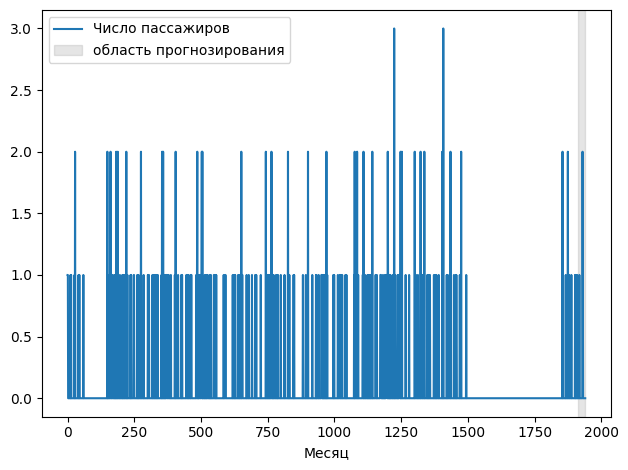

In [95]:
plt.plot(y, label='Число пассажиров')
plt.xlabel('Месяц')
plt.axvspan(len(train_data) - 1, len(y) - 1, color='#808080', alpha=0.2, label='область прогнозирования')


plt.legend()
plt.tight_layout()
plt.show()

In [96]:
from tqdm import tqdm
rolling_model = AutoARIMA(sp=12, max_p=100, max_q=100, suppress_warnings=True, random_state=413)
rolling_model.fit(train_data)
q = rolling_model.get_fitted_params()['order'][-1]
print('порядок MA(q): {q}'.format(q=q))
rolling_pred = [rolling_model.predict(fh=np.arange(1, max(q, 1)+1))]

rolling_quantile_pred = [rolling_model.predict_quantiles(fh=np.arange(1, max(q, 1)+1), alpha=QUANTILES)]

for i in tqdm(range(len(train_data) + max(q, 1), len(y), max(q, 1))):
    rolling_model.fit(y[:i])
    rolling_pred.append(rolling_model.predict(fh=list(range(1, max(q, 1)+1))))
    rolling_quantile_pred.append(rolling_model.predict_quantiles(fh=np.arange(1, max(q, 1)+1), alpha=QUANTILES))
    
rolling_quantile_pred = pd.concat(rolling_quantile_pred)
rolling_pred = np.concatenate(rolling_pred).flatten()



порядок MA(q): 1


100%|██████████| 27/27 [05:26<00:00, 12.10s/it]


rolling pl: [0.05397854 0.07451658 0.11818577 0.16395609 0.12639518]



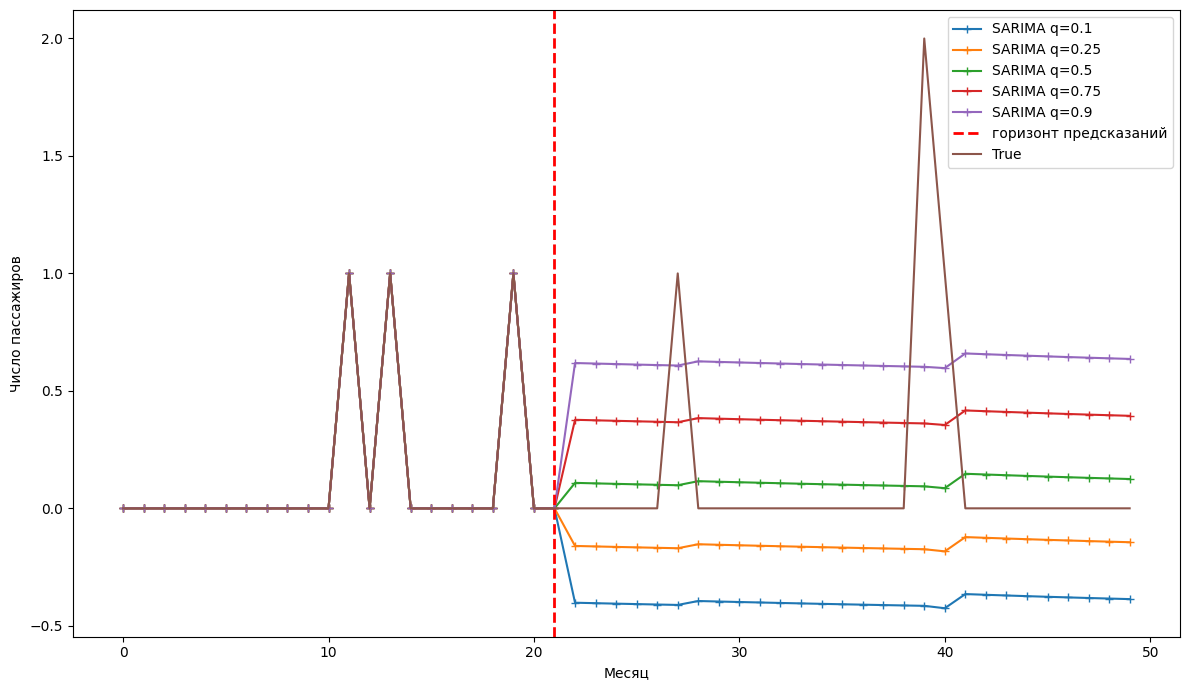

RMSE: 0.4407
R2: -0.0019
MAE: 0.2330

RMSE: 0.4482
R2: -0.0361
MAE: 0.2364



In [97]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss
pl = PinballLoss(score_average=False)
# print(f'naive pl: {pl(y[-28:], naive_quantile_pred).to_numpy()}')
print(f'rolling pl: {pl(y[-28:], rolling_quantile_pred).to_numpy()}\n')
# fig, axes = plt.subplots(len(QUANTILES), 1, figsize=(10, 15))
# for ax, quantile in zip(axes.flatten(), QUANTILES):
    
#     for name in ('Rolling', "Naive"):
#         if name == 'Rolling':
#             # ax.plot(np.concatenate((train_data, rolling_pred))[-70:], '--',label='SARIMA point')
#             ax.plot(np.concatenate((train_data, list(rolling_quantile_pred.to_dict()[(0, quantile)].values()))), '+-',label=f'SARIMA q={quantile}')
#         # else:
#         #     ax.plot(np.concatenate((train_data, naive_pred)), '--',label='Naive pred')
#         #     ax.plot(np.concatenate((train_data, list(naive_quantile_pred.to_dict()[(0, quantile)].values()))), '+-',label=f'Naive q={quantile}')
#         ax.axvspan(len(train_data) - 1, len(y) - 1, color='#808080', alpha=0.2)
#     ax.plot(y, label='True')
#     ax.legend()
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 7))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, list(rolling_quantile_pred.to_dict()[(0, quantile)].values())))[-50:], '+-',label=f'SARIMA q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('Месяц')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
for preds in [naive_pred, rolling_pred]:
    print(f'RMSE: {root_mean_squared_error(y_true=y[-28:], y_pred=preds):.4f}')
    print(f"R2: {r2_score(y_true=y[-28:], y_pred=preds):.4f}")
    print(f"MAE: {mean_absolute_error(y[-28:], y_pred=preds):.4f}\n")

# CatBoost

In [98]:
# y = passengers_df["Passengers"].values
M5_ID = "HOUSEHOLD_2_242_CA_1_evaluation"
y = m5_data[m5_data["id"] == M5_ID].filter(like='d_').values.flatten()
lags=[1, 2, 3, 7, 14, 30]
rolling_windows=[3, 7, 14, 30]
diff_periods=[1, 2, 3, 7, 14, 30]

df = pd.DataFrame({'target': y})
    
for lag in lags:
    df[f'lag_{lag}'] = df['target'].shift(lag)

for window in rolling_windows:
    df[f'rolling_mean_{window}'] = df['target'].shift(1).rolling(window=window).mean()
    df[f'rolling_std_{window}'] = df['target'].shift(1).rolling(window=window).std()


for period in diff_periods:
    df[f'diff_{period}'] = df['target'].diff(period)

df['target_future'] = df['target'].shift(-1)
df = df.iloc[:-1]

# df = df.dropna() #########3
display(df.shape)
display(df.head())

X = df.drop(columns=['target', 'target_future'])
y_target = df['target_future']

X_train, X_test = X[:-28], X[-28:]
y_train, y_test = y_target[:-28], y_target[-28:]
print(f"\nРазмеры данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

(1940, 22)

,target,lag_1,lag_2,lag_3,lag_7,lag_14,lag_30,rolling_mean_3,rolling_std_3,rolling_mean_7,...,rolling_std_14,rolling_mean_30,rolling_std_30,diff_1,diff_2,diff_3,diff_7,diff_14,diff_30,target_future
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0
3,0,0.0,1.0,1.0,NaN,NaN,NaN,0.666667,0.57735,NaN,...,NaN,NaN,NaN,0.0,-1.0,-1.0,NaN,NaN,NaN,0.0
4,0,0.0,0.0,1.0,NaN,NaN,NaN,0.333333,0.57735,NaN,...,NaN,NaN,NaN,0.0,0.0,-1.0,NaN,NaN,NaN,0.0



Размеры данных:
X_train: (1912, 20), y_train: (1912,)
X_test: (28, 20), y_test: (28,)


In [99]:
from catboost import CatBoostRegressor
models = {}
predictions = {}
rolling_predictions = {}
eval_results = {}

param_grid = {
    'depth': [4, 6, 8, 10],                    # Глубина деревьев
    'l2_leaf_reg': [1, 3, 5, 7, 10],          # L2 регуляризация
    'learning_rate': [0.01, 0.03, 0.05, 0.1], # Скорость обучения
    'iterations': [500, 1000, 1500],           # Количество итераций
    'random_strength': [0.1, 0.5, 1],         # Случайность при выборе разделений
    'bagging_temperature': [0, 0.5, 1],       # Температура бэггинга
    'leaf_estimation_iterations': [1, 5, 10], # Итерации для оценки листьев
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'] # Стратегия роста
}

for alpha in QUANTILES:
    print(f"\nОбучаем CatBoost для квантиля {alpha}...")

    model = CatBoostRegressor(
        loss_function=f'Quantile:alpha={alpha}',
        iterations=50_000,
        learning_rate=1e-2,
        depth=2,
        l2_leaf_reg=3,
        random_seed=SEED,
        verbose=100,  # Показываем прогресс каждые 100 итераций
        early_stopping_rounds=2_000,
        task_type='CPU',  # Можно изменить на 'GPU' если есть 
        train_dir = '../output/catboost_info'
    )
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=False,  # Можно установить True для визуализации обучения
        verbose_eval=0
    )
    predictions[alpha] = model.predict(X_test)
    models[alpha] = model

    HORIZON = 4
    rolling_pred = [model.predict(X_test[:HORIZON])]
    for i in tqdm(range(len(y_train) + HORIZON, len(y_target), HORIZON)):
        model.fit(
            X[:i], y_target[:i],
            eval_set=(X[i:], y_target[i:]),
            plot=False,  # Можно установить True для визуализации обучения
            verbose_eval=0
        )
        rolling_pred.append(model.predict(X[i:i+HORIZON]))
    rolling_predictions[alpha] = np.concatenate(rolling_pred)
    
    
    


Обучаем CatBoost для квантиля 0.1...


100%|██████████| 6/6 [00:27<00:00,  4.50s/it]



Обучаем CatBoost для квантиля 0.25...


100%|██████████| 6/6 [00:15<00:00,  2.55s/it]



Обучаем CatBoost для квантиля 0.5...


100%|██████████| 6/6 [00:11<00:00,  1.87s/it]



Обучаем CatBoost для квантиля 0.75...


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]



Обучаем CatBoost для квантиля 0.9...


100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


HORIZON 28
pl alpha=0.1: 0.014286505857142867
pl alpha=0.25: 0.0357149272493537
pl alpha=0.5: 0.07142881120628071
pl alpha=0.75: 0.10714316101074063
pl alpha=0.9: 0.12142857866346114
ROLLING HORIZON 4
pl alpha=0.1: 0.014286505857129638
pl alpha=0.25: 0.035714903017749815
pl alpha=0.5: 0.07142885088275776
pl alpha=0.75: 0.10721611543895009
pl alpha=0.9: 0.12130471028171289


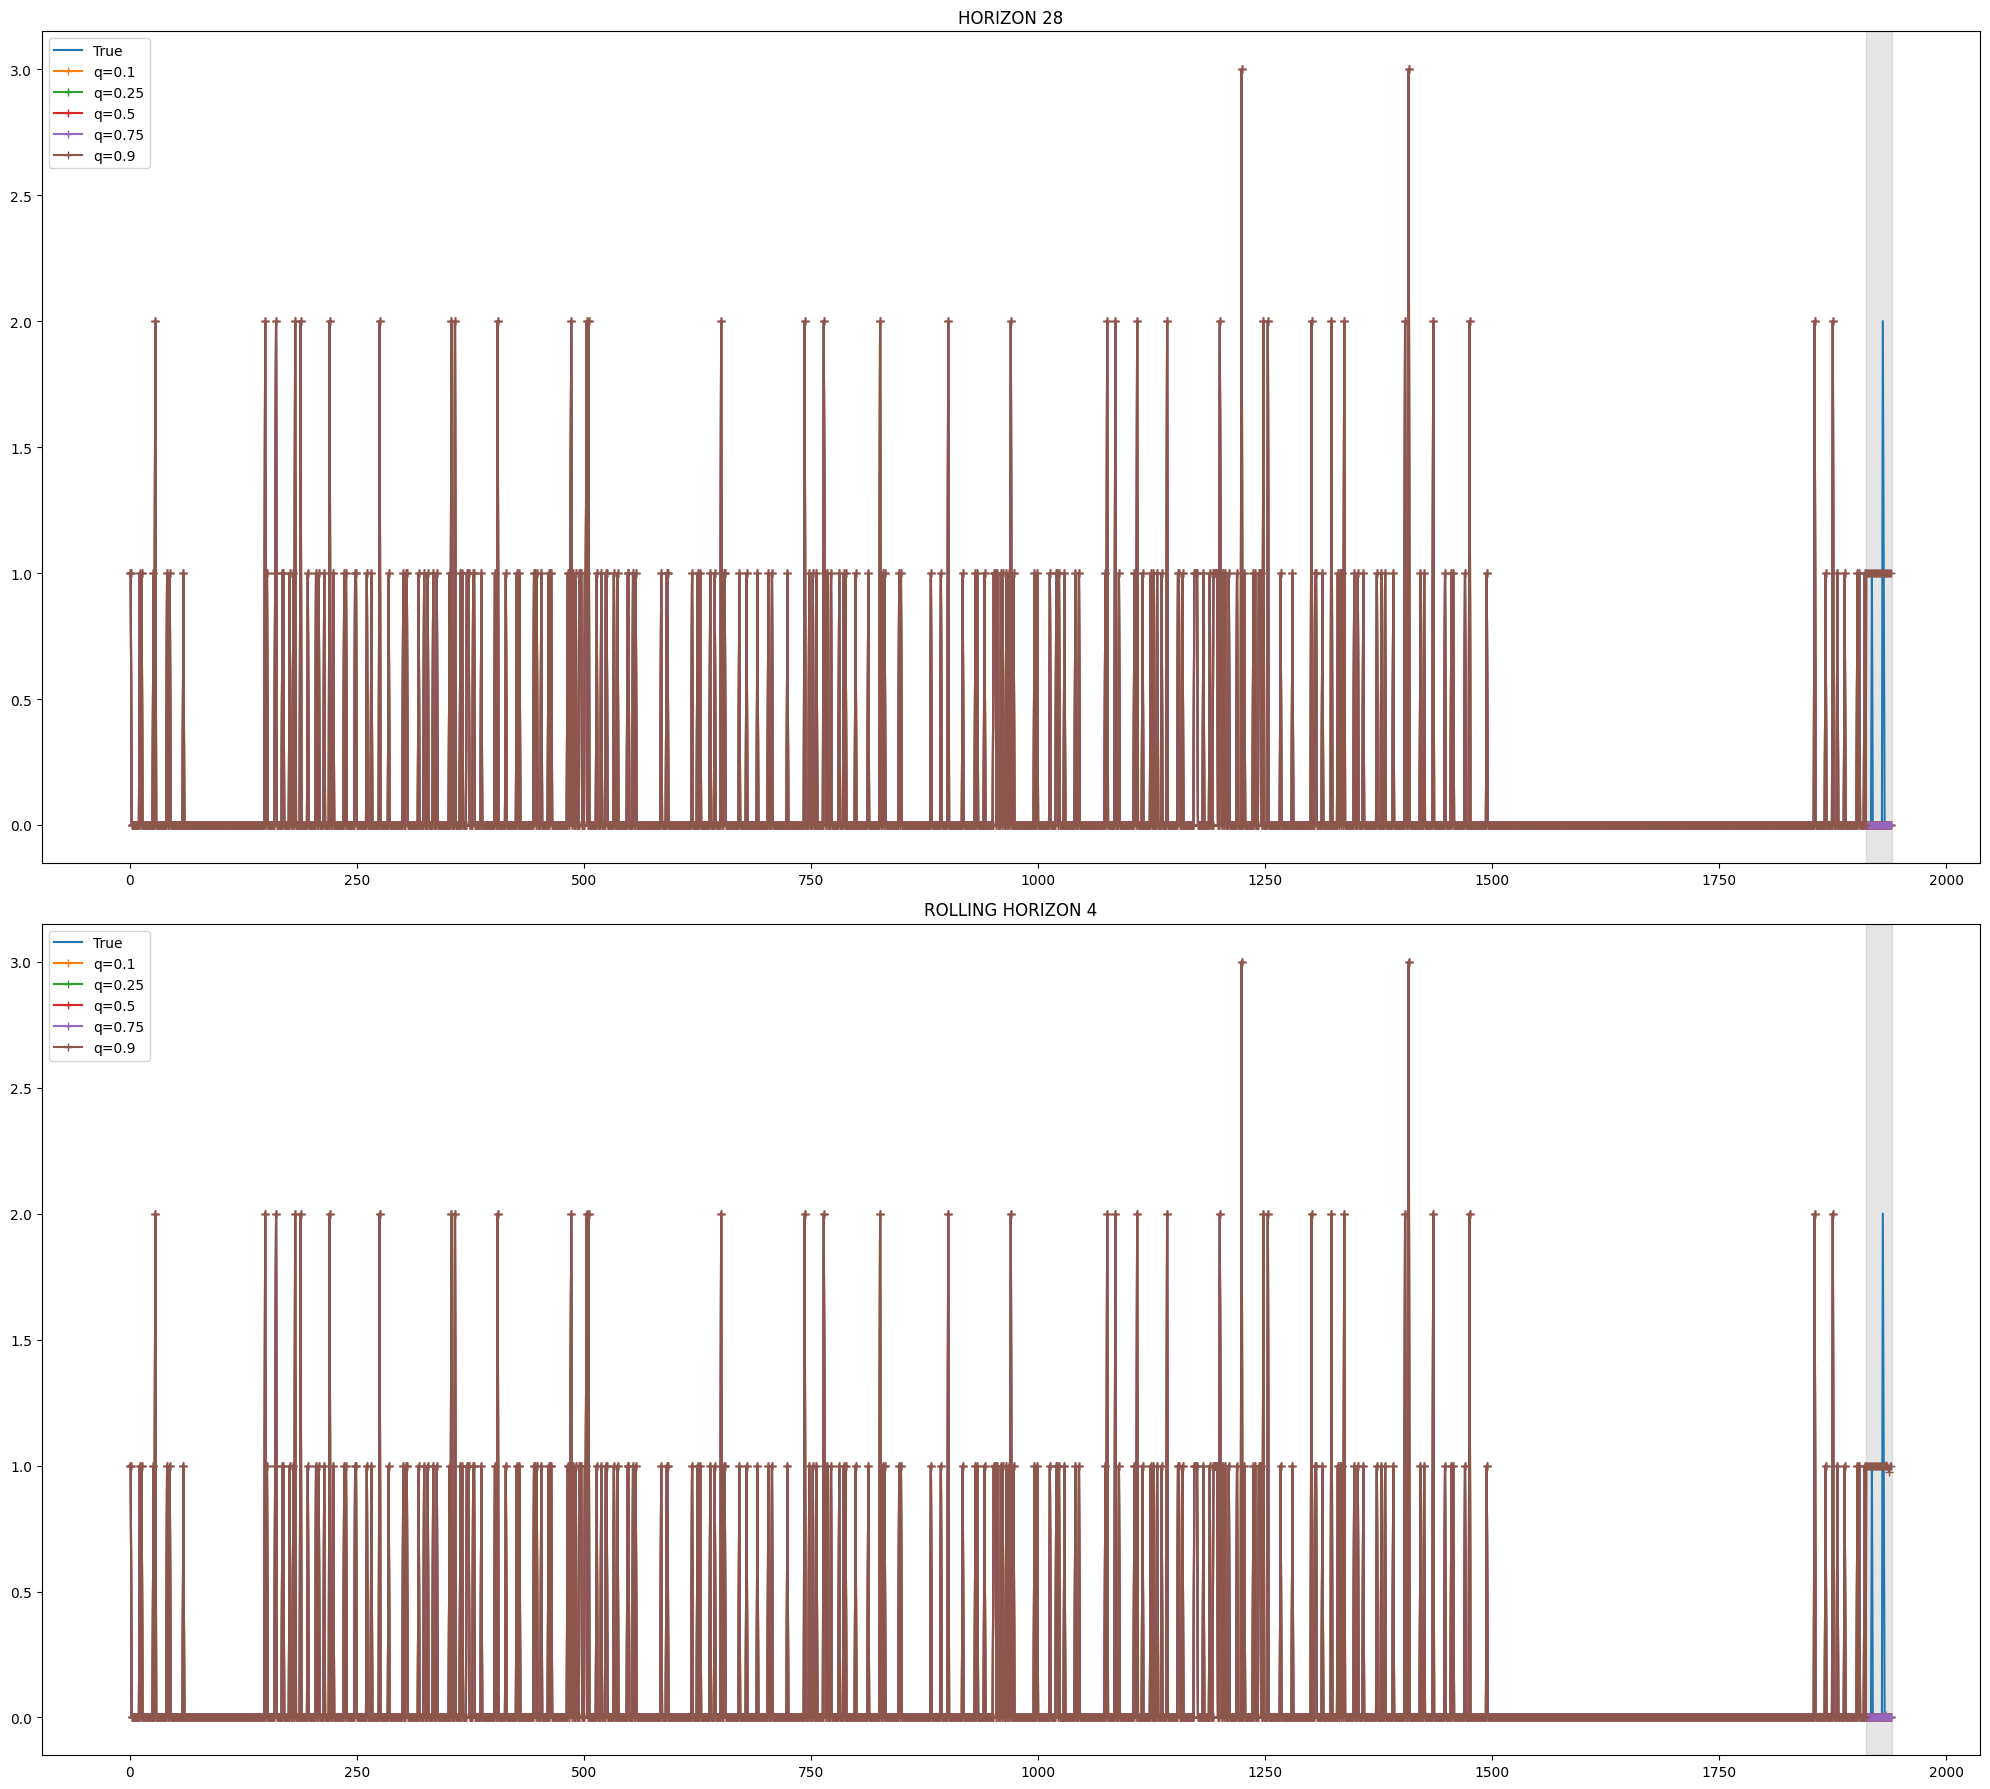

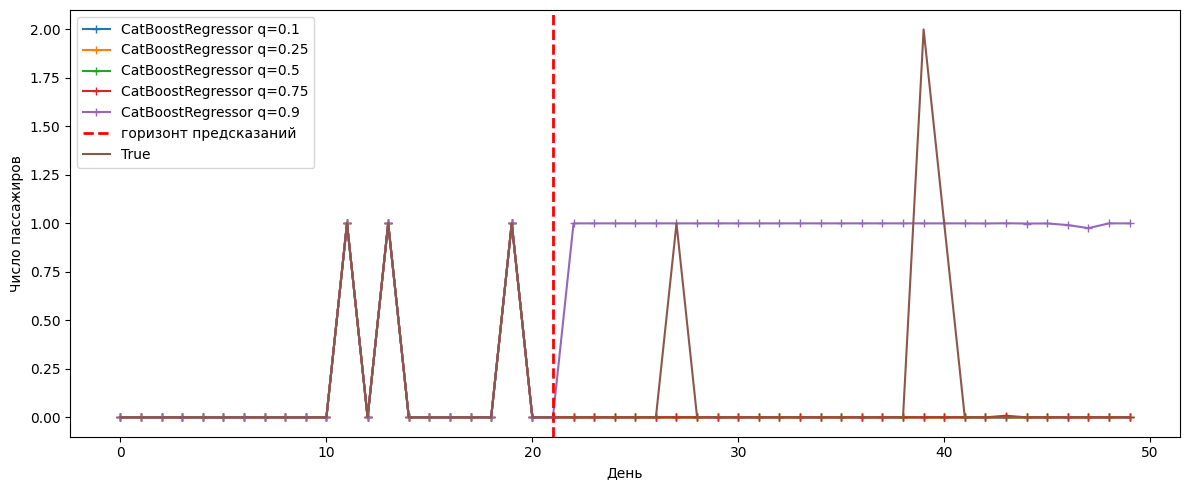

In [100]:
from sklearn.metrics import mean_pinball_loss, mean_absolute_error

print('HORIZON 28')
for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y_test, predictions[quantile], alpha=quantile)}')

print(f"ROLLING HORIZON {HORIZON}")
for quantile in QUANTILES:
    print(f'pl alpha={quantile}: {mean_pinball_loss(y[-28:], rolling_predictions[quantile], alpha=quantile)}')


fig, ax = plt.subplots(2, 1, figsize=(20, 18))
ax[0].plot(y, label='True')
ax[0].set_title('HORIZON 28')
for quantile in QUANTILES:
    ax[0].plot(np.concatenate((df["target"][:-28], predictions[quantile])), '+-',label=f'q={quantile}')
ax[0].axvspan(len(y_train) - 1, len(y) - 1, color='#808080', alpha=0.2)
ax[0].legend()

ax[1].plot(y, label='True')
ax[1].set_title(f"ROLLING HORIZON {HORIZON}")
for quantile in QUANTILES:
    ax[1].plot(np.concatenate((df["target"][:-28], rolling_predictions[quantile])), '+-',label=f'q={quantile}')
ax[1].axvspan(len(y_train) - 1, len(y) - 1, color='#808080', alpha=0.2)
ax[1].legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, list(rolling_predictions[quantile])))[-50:], '+-',label=f'CatBoostRegressor q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('День')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()


# ETS

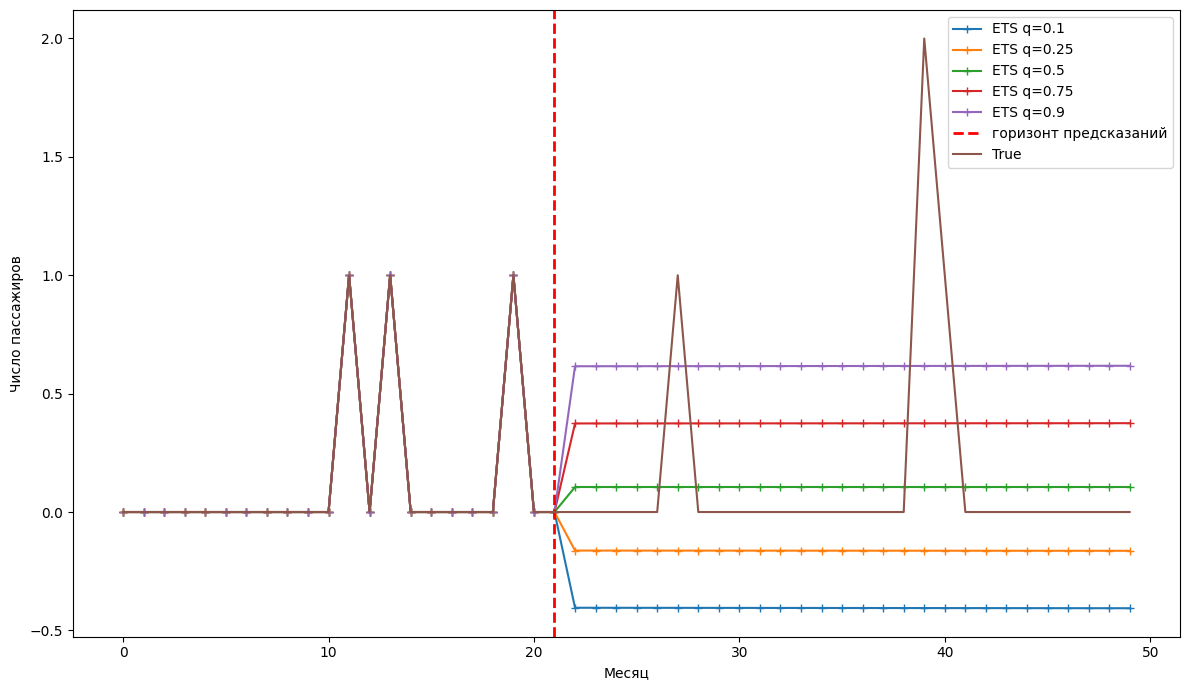

RMSE: 0.4419
R2: -0.0071
MAE: 0.2259


Результаты Pinball Loss:
Quantile 0.1: 0.5032
Quantile 0.25: 0.4322
Quantile 0.5: 0.3137
Quantile 0.75: 0.1952
Quantile 0.9: 0.1242


In [103]:
from sktime.forecasting.ets import AutoETS
QUANTILES = [0.1, 0.25, 0.5, 0.75, 0.9]
model = AutoETS(auto=True, sp=7, maxiter=10_000, random_state=173)
# y = passengers_df["Passengers"].values
M5_ID = "HOUSEHOLD_2_242_CA_1_evaluation"
y = m5_data[m5_data["id"] == M5_ID].filter(like='d_').values.flatten()
train_data = y[:-28]
model.fit(train_data)
ets_pred = model.predict(fh=np.arange(1, 28+1)).flatten()
ets_quantile_pred = model.predict_quantiles(fh=np.arange(1, 28+1), alpha=QUANTILES)


# Вспомогательная функция для извлечения из sktime DataFrame, если нужно
def get_sktime_preds(sktime_res, q):
    # sktime часто возвращает мультииндекс (coverage, quantile)
    # Адаптируйте индекс (0, q) под вашу версию sktime, если он отличается
    return list(sktime_res.to_dict()[(0, q)].values())

plt.figure(figsize=(12, 7))
for quantile in QUANTILES:
    plt.plot(np.concatenate((train_data, get_sktime_preds(ets_quantile_pred, quantile)))[-50:], '+-',label=f'ETS q={quantile}')
plt.axvline(x=21, color='r', linestyle='--', linewidth=2, label='горизонт предсказаний')
plt.plot(y[-50:], label='True')
plt.xlabel('Месяц')
plt.ylabel('Число пассажиров')

plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_pinball_loss

print(f'RMSE: {root_mean_squared_error(y_true=y[-28:], y_pred=ets_pred):.4f}')
print(f"R2: {r2_score(y_true=y[-28:], y_pred=ets_pred):.4f}")
print(f"MAE: {mean_absolute_error(y[-28:], y_pred=ets_pred):.4f}\n")

print("\nРезультаты Pinball Loss:")
for q in QUANTILES:
    loss = mean_pinball_loss(y[-28:], get_sktime_preds(ets_quantile_pred, quantile), alpha=q)
    print(f"Quantile {q}: {loss:.4f}")

# Vincentization

In [104]:
from utils.evaluation import evaluate_model_combinations

# 1. Подготовка данных (собираем всё в один словарь)
# Убедитесь, что все массивы одной длины (28 точек)

models_data = {
    'ARIMA': {},
    'CatBoost': {},
    'Prophet': {},
    'ETS': {}
}

for q in QUANTILES:
    # ARIMA (из sktime)
    # Важно: берем последние 28 точек, если там больше
    arima_vals = get_sktime_preds(rolling_quantile_pred, q)
    models_data['ARIMA'][q] = arima_vals[-28:] 
    
    # Предполагаем, что там numpy array
    models_data['CatBoost'][q] = rolling_predictions[q][-28:]
    
    # Prophet (ваш словарь prophet_quantile_predictions)
    models_data['Prophet'][q] = prophet_quantile_predictions[q][-28:]

    models_data["ETS"][q] = get_sktime_preds(ets_quantile_pred, q)


# 2. Запуск функции
# y_test[-28:] - это истинные значения за последние 28 дней
styled_table = evaluate_model_combinations(y_test[-28:], models_data, QUANTILES)

# 3. Отображение таблицы
styled_table

Квантиль   | Лучшая одиночная модель        | Лучшая комбинация (Overall)   
--------------------------------------------------------------------------------
0.1        | CatBoost               (0.0143) | CatBoost               (0.0143)
0.25       | CatBoost               (0.0357) | CatBoost               (0.0357)
0.5        | CatBoost               (0.0714) | CatBoost               (0.0714)
0.75       | CatBoost               (0.1072) | CatBoost               (0.1072)
0.9        | Prophet                (0.1200) | Prophet                (0.1200)



,ARIMA,CatBoost,ETS,Prophet,ARIMA + CatBoost,ARIMA + ETS,ARIMA + Prophet,CatBoost + ETS,CatBoost + Prophet,Prophet + ETS,ARIMA + CatBoost + ETS,ARIMA + CatBoost + Prophet,ARIMA + Prophet + ETS,CatBoost + Prophet + ETS,ARIMA + CatBoost + Prophet + ETS
0.100000,0.0540,0.0143,0.0548,0.0742,0.0341,0.0544,0.0641,0.0346,0.0442,0.0645,0.0410,0.0475,0.0610,0.0478,0.0493
0.250000,0.0745,0.0357,0.0765,0.1170,0.0551,0.0755,0.0957,0.0561,0.0763,0.0967,0.0623,0.0757,0.0893,0.0764,0.0759
0.500000,0.1182,0.0714,0.1129,0.0894,0.0948,0.1156,0.0893,0.0922,0.0804,0.0867,0.1009,0.0834,0.0972,0.0816,0.0908
0.750000,0.1640,0.1072,0.1607,0.1437,0.1356,0.1623,0.1538,0.1339,0.1255,0.1522,0.1439,0.1383,0.1561,0.1372,0.1439
0.900000,0.1264,0.1213,0.1242,0.1200,0.1238,0.1253,0.1232,0.1227,0.1206,0.1221,0.1240,0.1226,0.1235,0.1218,0.1230


# Defining of corresponding time series

In [105]:
# N_SERIES_TO_PROCESS = 1000
# sample_df = train_df.iloc[[30426, 0]]
# SEASONAL_PERIOD = 365  # Данные в M5 ежедневные, основная сезонность - недельная
# THRESHOLDS = {
#         'trend': 0.8,     # Сила тренда > 0.5 -> есть тренд
#         'season': 0.7,    # Сила сезонности > 0.5 -> есть сезонность
#         'clean': 0.85,     # Сила компоненты > 0.9 -> компонент "чистый" (мало шума)
#     }

# results = []
# for index, row in sample_df.iterrows():
#     series_id = row['id']
#     # Отбираем только столбцы с продажами (d_1, d_2, ...)
#     time_series = row.filter(like='d_').astype(float)
    
#     features = calculate_stl_features(time_series, period=SEASONAL_PERIOD)

#     if features:
#         classification = classify_series(features, THRESHOLDS)
#         results.append({
#             'id': series_id,
#             'classification': classification,
#             'trend_strength': features['trend_strength'],
#             'seasonal_strength': features['seasonal_strength'],
#             'noise_variance': features['noise_variance'],
#             'stl_result': features['stl_result'] # Сохраняем объект для графика
#         })

# stl_results_df = pd.DataFrame(results)
# print("--- Результаты классификации ---")
# display(stl_results_df[['id', 'classification', 'trend_strength', 'seasonal_strength']].head(10))
# print("\n--- Сводка по категориям ---")
# display(stl_results_df['classification'].value_counts())

# # ВИЗУАЛИЗАЦИЯ ПРИМЕРОВ
# print("\n--- Визуализация примеров из каждой найденной категории ---")

# unique_classifications = stl_results_df['classification'].unique()
# for cat in unique_classifications:
#     # Находим первый ряд, соответствующий этой категории
#     example = stl_results_df[stl_results_df['classification'] == cat].iloc[0]
    
#     print(f"\nПример для категории: '{cat}' (ID: {example['id']})")
    
#     # Отрисовываем его STL-декомпозицию
#     fig = example['stl_result'].plot()
#     fig.suptitle(f"Категория: {cat}\nID: {example['id']}", y=1.02)
#     plt.show()

In [106]:
# stl_results_df["classification"].value_counts()

In [107]:
# classification_res = "Seasonality + Noise"
# indx_lst = []
# for id in stl_results_df[stl_results_df["classification"] == classification_res]["id"].values:
#     index = train_df[train_df["id"] == id].index.item()
#     indx_lst.append(index)
# display(stl_results_df[stl_results_df["classification"] == classification_res]["id"])
# print(indx_lst)
# plot_series(indx_lst)
# # plt.plot(train_df[train_df["id"] == "HOBBIES_1_003_CA_1_evaluation"].values)

